#BackProp

In [40]:
import os
from PIL import Image
import numpy as np
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [41]:
DATA_PATH = "../DataSets/big_alphabet_29x29/"


In [215]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))


def d_sigmoid(z):
    return np.exp(-z)*((1 + np.exp(-z))**(-2))


def l2dist(pred, y):
    return np.sum((pred - y)**2, axis=1)


def d_l2dist(pred, y):
    return 2 * (pred - y)


def softmax(z):
    ex = np.exp(z)
    return ex / np.sum(ex)


def d_softmax(m):
    y = softmax(m)
    return y * (1 - y)

In [216]:
class MLP:
    def __init__(self, input_dimension=None,
                 layers=None,
                 f_activation=None,
                 df_activation=None,
                 n_steps=200,
                 seed=179,
                 regularization='L2',
                 learning_rate=0.01):
        np.random.seed(seed)

        if input_dimension is None:
            raise ValueError("Input dimension must not be None")

        if layers is None:
            self.n_layers = 10
            layers = [self.n_layers for _ in range(self.n_layers)]
        self.n_layers = len(layers)

        if f_activation is None or df_activation is None:
            f_activation = [sigmoid for _ in range(self.n_layers)]
            df_activation = [d_sigmoid for _ in range(self.n_layers)]

        self.w = [None] * self.n_layers
        for i in range(0, self.n_layers):
            prev = (layers[i - 1] if i != 0 else input_dimension)
            nxt = layers[i]
            self.w[i] = np.random.uniform(-0.1, 0.1, (prev + 1, nxt))

        self.layers = layers
        self.f_activation = f_activation
        self.df_activation = df_activation

        self.loss = l2dist
        self.d_loss = d_l2dist
        self.n_steps = n_steps
        self.regularization = regularization

        self.learning_rate = learning_rate

    def fit(self, X, Y, val_x, val_y, add_bias=True):
        if add_bias:
            X = np.concatenate((X, np.ones(X.shape[0]).reshape(X.shape[0], 1)), axis=1)

        err_tr = list()
        err_val = list()
        Xs = [None] * self.n_layers
        fXs = [None] * self.n_layers

        for t in range(self.n_steps):
            tmp = X
            for i in range(self.n_layers):
                Xs[i] = np.dot(tmp, self.w[i])
                tmp = self.f_activation[i](Xs[i])
                fXs[i] = tmp
                if i != self.n_layers - 1:
                    tmp = np.concatenate((tmp, np.ones(tmp.shape[0]).reshape(tmp.shape[0], 1)), axis=1)

            err_tr.append(self.loss(fXs[-1], Y).mean())
            err_val.append(self.loss(self.predict(val_x), val_y).mean())

            gradW = [None] * self.n_layers
            dE_n = None
            for i in reversed(range(self.n_layers)):
                dE = None
                if i == self.n_layers - 1:
                    dE = self.d_loss(fXs[i], Y) * self.df_activation[i](Xs[i])
                    dE_n = dE
                else:
                    dE = np.dot(self.w[i + 1][:-1, :], dE_n.T).T * self.df_activation[i](Xs[i])
                    dE_n = dE
                
                inp = None
                if i == 0:
                    inp = X
                else:
                    inp = np.concatenate((fXs[i - 1], np.ones(fXs[i - 1].shape[0]).reshape(fXs[i - 1].shape[0], 1)), axis=1)

                gradW[i] = np.dot(inp.T, dE) / len(X)
            #print gradW
            for i in range(self.n_layers):
                if self.regularization == 'L2':
                    gradW[i] += 2*self.w[i]
                self.w[i] -= self.learning_rate * gradW[i]

        return err_tr, err_val

    def predict(self, X, add_bias=True):
        if add_bias:
            X = np.concatenate((X, np.ones(X.shape[0]).reshape(X.shape[0], 1)), axis=1)

        tmp = np.copy(X)
        #print tmp
        for i in range(0, self.n_layers):
            tmp = np.dot(tmp, self.w[i])
            tmp = self.f_activation[i](tmp)
            #print tmp
            if i != self.n_layers - 1:
                tmp = np.concatenate((tmp, np.ones(tmp.shape[0]).reshape(tmp.shape[0], 1)), axis=1)

        return tmp

In [217]:
train = list()
y = list()

test_ = list()
test_y = list()


val = list()
val_y = list()
for pt in os.listdir(DATA_PATH):
    im = Image.open(os.path.join(DATA_PATH, pt))
    gr = list()
    for rw in np.array(im):
        for el in rw:
            gr.append(el.sum() / 3 / 255)
    if "class" in pt:
        train.append(np.array(gr))
        cy = int(pt[6:-4])
        y.append([1 if i == cy else -1 for i in range(26)])
    else:
        test_.append(np.array(gr))
        cy = int(pt.split("-")[1])
        test_ans.append(cy)
        test_y.append([1 if i == cy else -1 for i in range(26)])
    
    if "-7-0" in pt:
        val.append(np.array(gr))
        cy = int(pt[7:-8])
        val_y.append([1 if i == cy else -1 for i in range(26)])
    
train = np.array(train)
y = np.array(y)
test_ = np.array(test_)
test_y = np.array(test_y)

val = np.array(val)
val_y = np.array(val_y)

In [218]:
print val.shape
print val_y.shape

(27, 841)
(27, 26)


In [219]:
mlp = MLP(input_dimension=29*29, 
          layers=[70 for i in range(1)] + [26], 
          f_activation=[sigmoid, sigmoid], 
          df_activation=[d_sigmoid, d_sigmoid],  
          n_steps=1000,
          learning_rate=0.01)

In [220]:
errors_train, error_val = mlp.fit(train, y, val, val_y)

In [221]:
mlp.predict(train[0:4:, ::])

array([[ 0.05137246,  0.05138698,  0.05135815,  0.05137809,  0.0513771 ,
         0.05136624,  0.05137456,  0.05138655,  0.05133873,  0.05134921,
         0.05137387,  0.05135834,  0.05142129,  0.05139437,  0.05137419,
         0.05137326,  0.05137998,  0.05138497,  0.05136531,  0.05136283,
         0.05137585,  0.05136376,  0.05142673,  0.05137098,  0.05135252,
         0.05136718],
       [ 0.05180213,  0.05181672,  0.05178774,  0.05180779,  0.05180679,
         0.05179588,  0.05180424,  0.05181629,  0.05176823,  0.05177876,
         0.05180355,  0.05178793,  0.0518512 ,  0.05182415,  0.05180387,
         0.05180294,  0.05180969,  0.0518147 ,  0.05179494,  0.05179245,
         0.05180553,  0.05179338,  0.05185667,  0.05180064,  0.05178208,
         0.05179682],
       [ 0.05141416,  0.05142869,  0.05139984,  0.05141979,  0.0514188 ,
         0.05140794,  0.05141626,  0.05142826,  0.05138041,  0.0513909 ,
         0.05141558,  0.05140003,  0.05146301,  0.05143609,  0.05141589,
       

In [203]:
print errors_train, "\n -------------------"

print error_val

[56.465510169215776, 52.814646135358494, 49.48200727026525, 46.35539037890765, 43.48920240816301, 40.981061994219083, 38.880029618287253, 37.170974715064773, 35.800465017609945, 34.70491566887069, 33.825879222307336, 33.115136329040936, 32.534880922527989, 32.05618288317725, 31.657124781404285, 31.321125100319161, 31.035588135932468, 30.790874707515918, 30.579539177660685, 30.395771084091095, 30.234987916846851, 30.093537456690267, 29.968478989751397, 29.857421323967891, 29.758401885630295, 29.669795709908119, 29.590246334659096, 29.518612854810083, 29.453928984363113, 29.395371106069547, 29.342233101956058, 29.293906344226166, 29.249863649902942, 29.209646309388525, 29.172853521635091, 29.139133730603696, 29.10817747632321, 29.079711461490401, 29.053493599946332, 29.029308862721106, 29.006965775031496, 28.986293446746046, 28.967139041614185, 28.949365608590167, 28.932850213022586, 28.917482317164936, 28.903162368992145, 28.889800566114914, 28.877315767978569, 28.865634534746658, 28.85

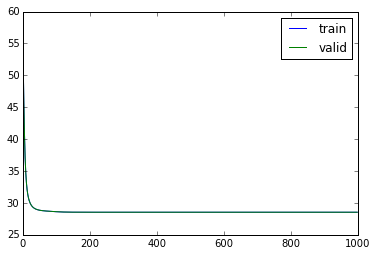

In [204]:
pl.plot(errors_train, label="train")
pl.plot(error_val, label="valid")
pl.legend()
pl.show()

In [209]:
test_

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [210]:
pr = mlp.predict(test_)

In [211]:
ans = np.argmax(pr, axis=1)

In [212]:
zip(ans, test_ans)

[]

array([22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22